In [2]:
# import all necessary libraries
import numpy as np
import cv2
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

2024-07-25 22:54:36.876835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 22:54:36.886270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 22:54:36.896103: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 22:54:36.899068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 22:54:36.906456: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
image_path = "/home/eiiv-nn1-l3t04/Project/dataset/training/image1.jpg"
original_image = cv2.imread(image_path)
# Convert the image to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

def plot_image(img, description):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(description)
    plt.axis('off')


In [ ]:
gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# show the original and blurred images
plot_image(gray, "Gray image")
_, threshold = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY) 


In [1]:
import cv2
import numpy as np

# Function to detect an object and return its bounding box, coordinates, and orientation
def detect_object(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print("Shape of the image", gray.shape) 
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is the object
    contour = max(contours, key=cv2.contourArea)
    
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate the center of the bounding box
    cx, cy = x + w // 2, y + h // 2
    moments = cv2.moments(contour)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        cy = int(moments["m01"] / moments["m00"])
    else:
        cx, cy = 0, 0
    angle = 0.5 * np.arctan2(2 * moments["mu11"], moments["mu20"] - moments["mu02"])

    # Calculate orientation (angle) using PCA
    data = np.array(contour[:, 0, :], dtype=np.float64)
    mean, eigenvectors = cv2.PCACompute(data, mean=np.empty((0)))
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0])

    annotated_image = image.copy()
    cv2.rectangle(annotated_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.circle(annotated_image, (cx, cy), 5, (0, 255, 255), -1)
    cv2.putText(annotated_image, f"Angle: {np.degrees(angle):.2f}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.imshow(annotated_image)
    
        # Crop the image around the object
    output_size = (800, 800)
    #cropped_image = annotated_image[y:y+h, x:x+w]
    cropped_image = annotated_image[y:y+h, x:x+w]
    # Resize the cropped image to the desired output size
    resized_image = cv2.resize(cropped_image, output_size)
    #plt.imshow(resized_image)

    return (x, y, w, h), (cx, cy), angle

# Example usage
image = cv2.imread("/home/eiiv-nn1-l3t04/Project/dataset/training/image2.jpg")
bbox, coordinates, orientation = detect_object(image)



print(f"Bounding Box: {bbox}")
print(f"Coordinates: {coordinates}")
print(f"Orientation: {orientation}")


Shape of the image (3040, 4056)


NameError: name 'plt' is not defined

In [ ]:
import rospy
from sensor_msgs.msg import Image
from std_msgs.msg import Float32MultiArray
from cv_bridge import CvBridge

def publish_data(image, bbox, center, angle):
    rospy.init_node('object_detection_node', anonymous=True)
    
    image_pub = rospy.Publisher('/annotated_image', Image, queue_size=10)
    data_pub = rospy.Publisher('/object_data', Float32MultiArray, queue_size=10)
    
    bridge = CvBridge()
    ros_image = bridge.cv2_to_imgmsg(image, "bgr8")
    image_pub.publish(ros_image)
    
    data_msg = Float32MultiArray()
    data_msg.data = [*bbox, *center, angle]
    data_pub.publish(data_msg)
    
    rospy.spin()

# Example usage
publish_data(annotated_image, bbox, center, angle)


In [ ]:
import torch
import torchvision.transforms as T
import cv2
from transformers import DetrForObjectDetection, DetrFeatureExtractor
import numpy as np

# Load pre-trained ViT model and feature extractor
model_name = "facebook/detr-resnet-50"
model = DetrForObjectDetection.from_pretrained(model_name)
feature_extractor = DetrFeatureExtractor.from_pretrained(model_name)

# Function to perform object detection and pose estimation
def detect_and_estimate_pose(image):
    # Convert the image to the format required by the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Perform inference
    outputs = model(**inputs)
    
    # Extract bounding boxes and labels
    target_sizes = torch.tensor([image.shape[:2]])
    results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
    
    annotated_image = image.copy()
    
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if score > 0.7:  # Confidence threshold
            box = box.int().numpy()
            cv2.rectangle(annotated_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            label_text = f"{model.config.id2label[label.item()]}: {score.item():.2f}"
            cv2.putText(annotated_image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return annotated_image

# Load an image
image_path = '/home/eiiv-nn1-l3t04/Project/dataset/training/image1.jpg'
image = cv2.imread(image_path)

# Perform detection and pose estimation
annotated_image = detect_and_estimate_pose(image)

# Display annotated image
#cv2.imshow("Annotated Image", annotated_image)
plt.imshow(annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('/home/eiiv-nn1-l3t04/Project/dataset/training/image1.jpg')
plt.imshow(image)
image2 = cv2.resize(image, (200, 200))
plt.imshow(image2)

Loading pre-trained VGG16 model....
Loading of model complete!
height 200
weight 200
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Inside extract feature function..
Inside loop...
1/1 ━━━━━━━━━━━━━━━━━

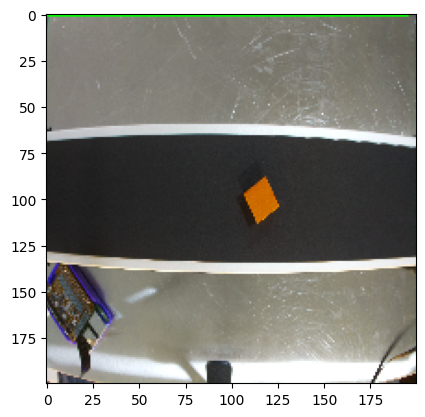

In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model
print("Loading pre-trained VGG16 model....")
model = VGG16(weights='imagenet', include_top=False)
print("Loading of model complete!")
# Function to extract features using VGG16
def extract_features(image, model):
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image)
    print("Inside extract feature function..")
    return features.flatten()

# Function to apply k-means clustering to the features
def apply_kmeans(features, k=2):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
    return kmeans.cluster_centers_, kmeans.labels_

# Function to draw bounding boxes around detected objects
def draw_bounding_boxes(image, centers, labels):
    h, w, _ = image.shape
    for i, center in enumerate(centers):
        y, x = divmod(center, w)
        print("Y",y)
        print("X",x)
        #cv2.rectangle(image, (x-20, y-20), (x+20, y+20), (0, 255, 0), 2)
        cv2.rectangle(image, (x[1], y[1]), (x[0], y[0]), (0, 255, 0), 2)
    return image

# Load the image
image = cv2.imread('/home/eiiv-nn1-l3t04/Project/dataset/training/image1.jpg')
image = cv2.resize(image, (200, 200))
h, w, _ = image.shape

# Extract features from image patches
patch_size = 5
features = []
positions = []
print("height", h)
print("weight", w)
for y in range(0, h, patch_size):
    for x in range(0, w, patch_size):
        patch = image[y:y+patch_size, x:x+patch_size]
        if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
            continue
        print("Inside loop...")
        feature = extract_features(patch, model)
        features.append(feature)
        positions.append((y, x))

features = np.array(features)
positions = np.array(positions)

# Apply k-means clustering to the features
centers, labels = apply_kmeans(features, k=5)

# Draw bounding boxes around detected objects
output_image = draw_bounding_boxes(image.copy(), positions[labels == 1], labels)

# Display the result
#cv2.imshow('Unsupervised Object Detection', output_image)
plt.imshow(output_image)
cv2.waitKey(0)
cv2.destroyAllWindows()
